In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import sklearn
import cv2

plt.style.use('seaborn')
np.__version__

/tmp/ipykernel_71213/1712746027.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

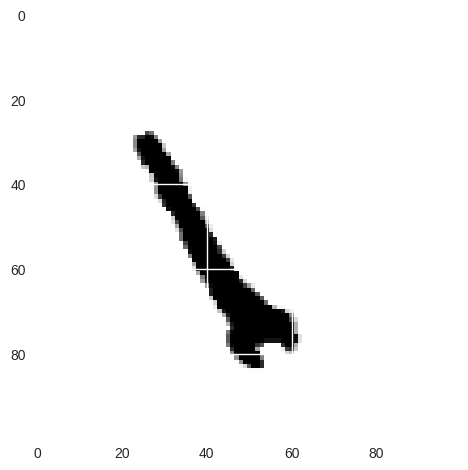

In [2]:
PATH = './Data/KIMIA dataset/tool22.png'

img = plt.imread(PATH)
img = cv2.resize(img, (100, 100))
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

plt.imshow(img)


In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

In [3]:
from math import atan2, cos, sin, sqrt, pi

def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = atan2(p[1] - q[1], p[0] - q[0])
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

def get_orientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    
    mean = np.empty((0))
    # find the eigenvectors and eigvalues
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    cntr = (0, 0)
    # PCA1
    p1 = (cntr[0] + 1 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 1 * eigenvectors[0,1] * eigenvalues[0,0])
    # draw the pc vector
    draw_axis(img, cntr, p1, (0, 150, 0), 1)
    return p1

In [4]:
# do pca on the image and find the max variance pc
# The alignment of the image is parallel to this vector

def do_pca(PATH):
    img = plt.imread(PATH)
    img = cv2.resize(img, (100, 100))
    img2 = img.copy()
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    _, bw = cv2.threshold(gray, 50, 200, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
    img = cv2.drawContours(img, contours[0], 0, (0, 0, 255), 2)
    p1 = get_orientation(contours[0], img)

    # plt.imshow(img[:, :, :1])
    plt.show()
    return p1/np.linalg.norm(p1), img


In [5]:
PATH = './Data/KIMIA dataset/'
template_img = os.path.join(PATH, 'tool22.png')
img = os.path.join(PATH, 'fgen1ap.png')

p1, img1 = do_pca(template_img)
p2, img2 = do_pca(img)

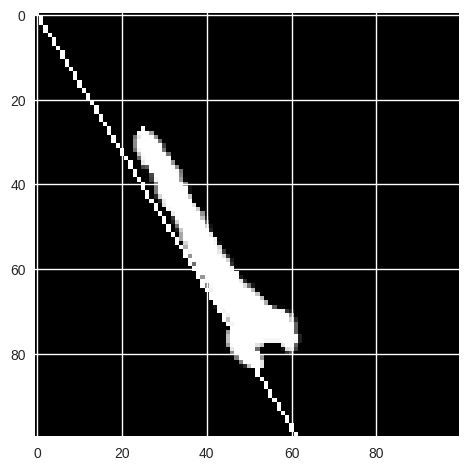

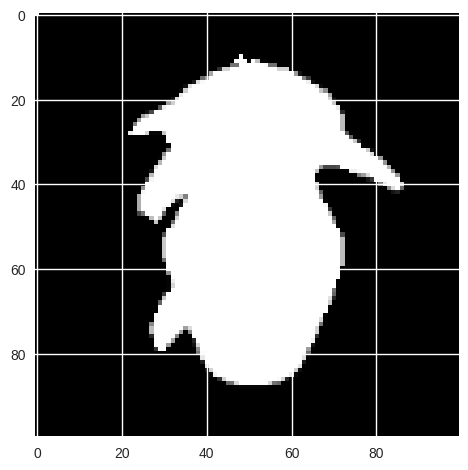

In [6]:
plt.imshow(img1[:, :, :1])
plt.show()
plt.imshow(img2[:, :, :1])

In [7]:
p1, p2

(array([0.52361131, 0.85195727]), array([-0.22429668,  0.97452091]))

In [8]:
def rotate_image(img, angle):
    R = cv2.getRotationMatrix2D((50, 50), -angle, 1.0)
    img = cv2.warpAffine(img, R, (100, 100))
    return img
    
def load_img(path):
    img = plt.imread(path)
    img = cv2.resize(img, (100, 100))
    return img

rotated_images = []

for i, img_path in enumerate(os.listdir(PATH)):
    # some images (about 3) have weird pc1, so need to remove them. 
    try:
        p2, img = do_pca(os.path.join(PATH, img_path))
        angle = np.sign(np.cross(p2, p1)) * np.rad2deg(np.arccos(np.dot(p1, p2)))
        img = rotate_image(img, angle)
        rotated_images.append(img) 
    except:
        print(img_path)    

/tmp/ipykernel_71213/3285785303.py:17: RuntimeWarning: invalid value encountered in divide
  return p1/np.linalg.norm(p1), img


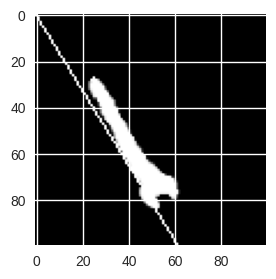

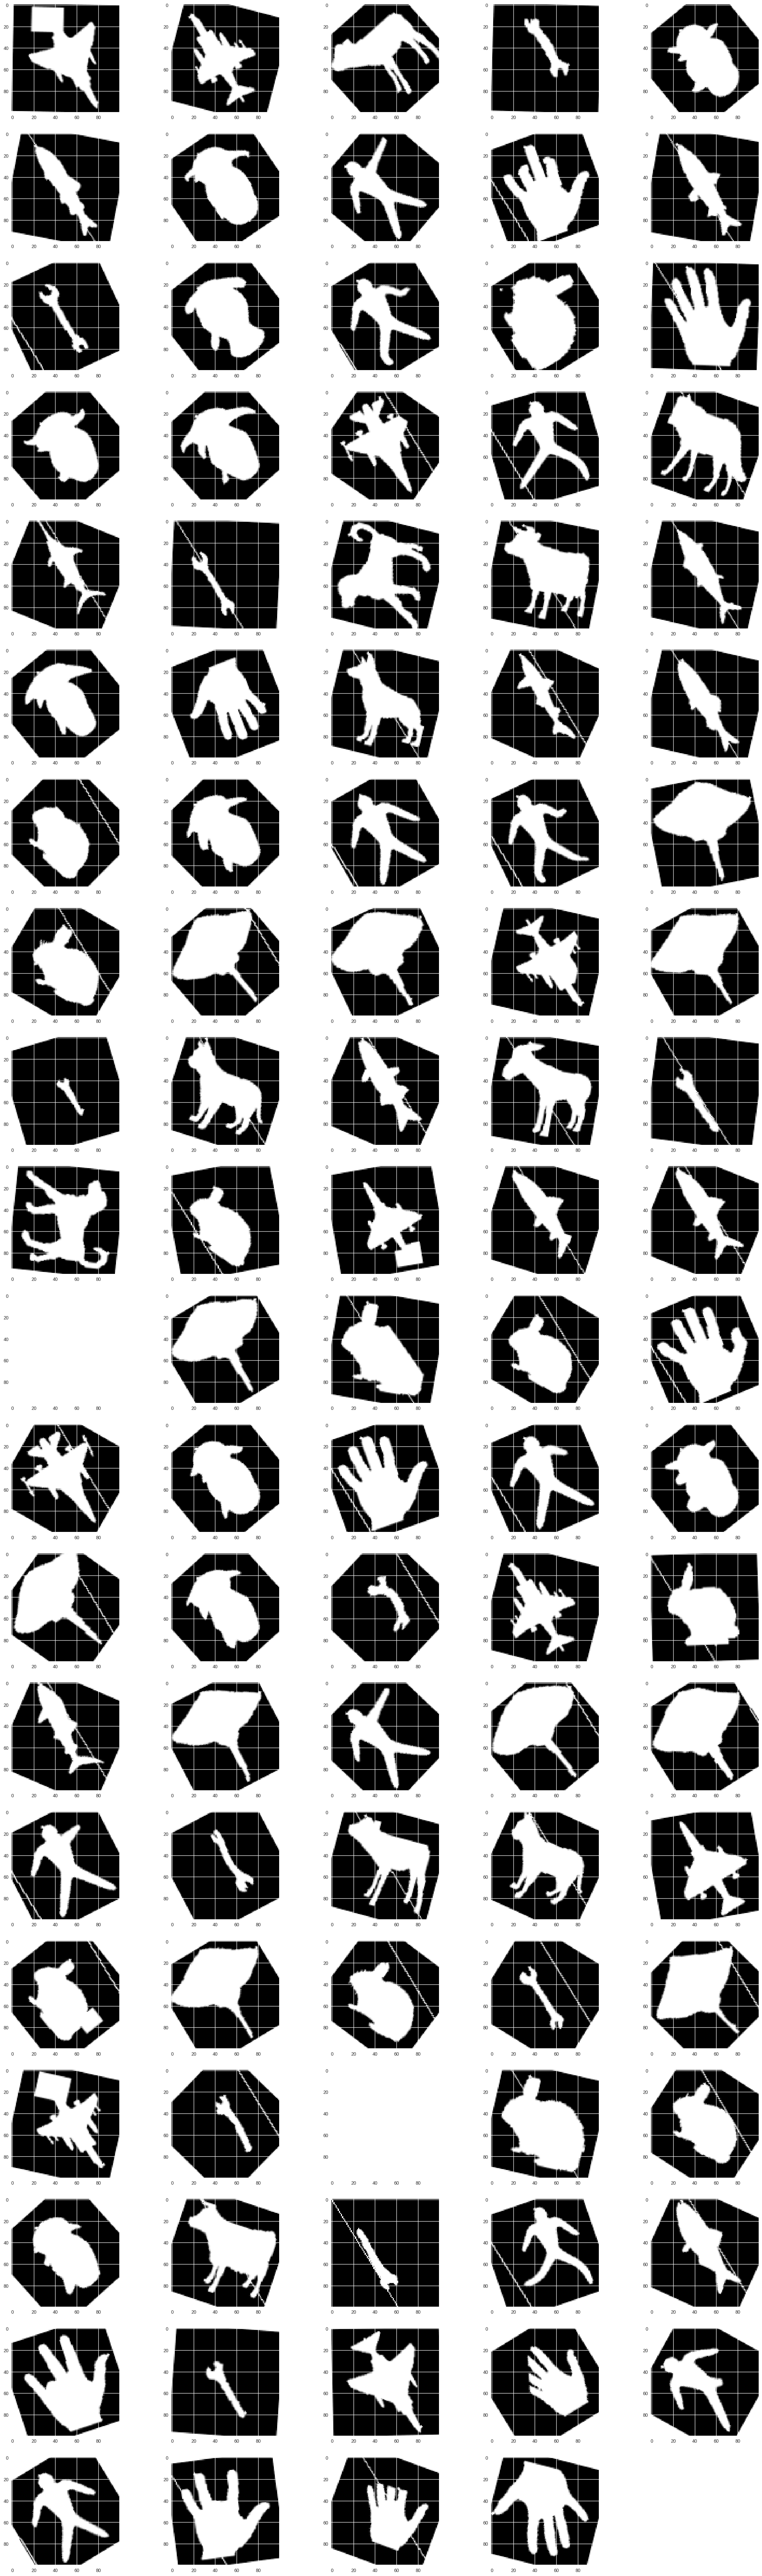

In [9]:
plt.figure(figsize=(5, 3))
plt.imshow(img1[:, :, :1])

plt.figure(figsize=(30, 100))
for i, img in enumerate(rotated_images):
    plt.subplot(20, 5, i + 1)
    plt.imshow(img[:, :, :1])

## Flowchart

![image](./utils/algo-flowchart.png)